# <font color='#FBD5AB'>MODEL BUILDING</font>

#### Setting up our connections with Google drive. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



%cd /gdrive/My Drive/CCI Case study/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/CCI Case study


### Importing the required packages

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


import warnings
warnings.filterwarnings("ignore")

### Define helper functions.

In [5]:
def create_sequences(data, lookback_period, forecast_window):
  ''' 
  Creating Sequences of data, in such a way that we can input it
   into the LSTM architecture

   Inputs:
    data: the dataset for which we want to create the sequences for
    lookback_periods: how many data points the model should look back at
    forecasting window: how much into the future we want to make predictions

  Outputs:
    X and y arrays
  '''

  X = []
  y = []
  for i in range(lookback_period, len(data)-forecast_window):
      X.append(data[i-lookback_period:i, :])
      y.append(data[i:i+forecast_window, 0])
  X, y = np.array(X), np.array(y)
  return X, y

In [6]:
def invert_scale(arr, series):
  '''The function inverts the scale from noramlized
     series to un-normalized series'''
  scaled_pred = []
  scaler1 = MinMaxScaler()
  scaler1.fit(np.array(series).reshape(-1, 1))
  for i in arr:
    scaled_pred.append(scaler1.inverse_transform(i.reshape(1, len(i))).flatten())
  return np.array(scaled_pred)

In [7]:
def get_last_val(data, lookback_period, forecasting_window):
  '''Get the Last actual value for each
     sequence formed. These values will help us 
     de-difference the time series.

     output: Array with last Value'''
  last_vals = []
  for i in range(lookback_period, len(data)-forecasting_window):
      last_vals.append(data[i-1, 0])
  return np.array(last_vals)


In [8]:
def invert_trend(arr, last):
  '''De-Difference the time series, based
  on the last values obtained from the get_last_val
  function.

  input: predicted values array
  output: output de-differenced predictions'''
  for i in range(arr.shape[1]):
    k = arr[:, i] + last
    arr[:, i] = k
    last = k
  return arr

In [9]:
def get_dict(arr):
  '''Convert the output in form of a dictionary;
  readable format with keys being the input keys 
  being the number of time points in the future
  and values being the array for that time point into 
  future predictions.
  
  input: predictions array
  output: dictionary'''
  predictions = {i+1: arr[:, i] for i in range(arr.shape[1])}
  return predictions

In [10]:
def model_evaluation(predictions, actual):
  '''
  Makes a plot of Mean Absolute Errors with each 
  corresponding timepoint into the future. 
  
  Inputs: 
    predictions: predictions from model
    actual: truth values
  Outputs:
    Make a plot for the MAEs
    '''

  Maes = []
  for i in actual:
    mae = mean_absolute_error(predictions[i], actual[i])
    Maes.append(mae)


  plt.subplots(1,2, figsize=(18, 7))
  plt.subplot(1,2,1)
  plt.plot(actual[1], label= "Actual")
  plt.plot(predictions[1], label= "Forecasted")
  plt.ylabel('Brent Crude Oil Prices')
  plt.title('1 Business Days in Future Forecasts.   ' + f'(MAE={Maes[0]:.3f})')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(actual[7], label= "Actual")
  plt.plot(predictions[7], label= "Forecasted")
  plt.ylabel('Brent Crude Oil Prices')
  plt.title('7 Business Days in Future Forecasts.   ' + f'(MAE={Maes[6]:.3f})')
  plt.legend()

### We will proceed with organizing the data in order of feature importance and subset the first N important features. We will then run the model with those features iteratively to evaluate the best features, while keeping the model architecture fixed.

In [11]:
def get_x_imp(arr, n):
  '''Return the data with n most important features
  
  input: array 
  output: subsetted array'''
  return_arr = []
  for i in range(arr.shape[0]):
    return_arr.append(arr[i][:, :n])

  return np.array(return_arr)
  

### Define the model.

In [12]:
class forecasting_model():

  def __init__(self, lookback, forecasting_window, input_feature, lr=1e-3, epochs=200, batch_size=64, l2_pen = 0):
    '''Instatiate the Model with these parameters'''
    self.model = None
    self.lookback = lookback
    self.forecasting_window = forecasting_window
    self.input_feature = input_feature
    self.check_point = None
    self.lr = lr
    self.batchsize = batch_size
    self.epochs = epochs
    self.l2_pen = l2_pen


  def create_model(self):
    '''Create a model'''
    model = Sequential()
    model.add(LSTM(64, input_shape=(self.lookback, self.input_feature), return_sequences=True))
    model.add(LSTM(32, kernel_regularizer= l2(self.l2_pen)))
    model.add(Dropout(0.3))
    model.add(Dense(self.forecasting_window, kernel_regularizer= l2(self.l2_pen)))

    self.checkpoint = ModelCheckpoint(filepath='my_model.h5', 
                                          monitor='val_loss', 
                                          save_best_only=True, 
                                          save_weights_only=False, 
                                          mode='min', 
                                          verbose=0)
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr))
    return model

  def fit(self, X_train, y_train, X_val=None, y_val= None, silent = False):
    ''' Fit the Model'''
    self.model = self.create_model()

    if silent:
      v = 0
    else:
      v =1 

    # Train the model
    if (X_val is None) and (y_val is None):
      self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batchsize, verbose = v)
    else:
      self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batchsize, validation_data=(X_val, y_val), callbacks=[self.checkpoint], verbose = v)

  
  def predict(self, X_test):
    ''' Make predictions using the model on the test data'''
    best_model = tf.keras.models.load_model('my_model.h5')
    preds = best_model.predict(X_test)
    return preds


#### Loading the data and organizing the columns in order of importance. 

In [ ]:
data = pd.read_csv('Data for Modelling.csv', index_col=1)
data = data.iloc[:, 1:]


imp_feat = [
  'BRENT',
  'Next Futures Avg',
  'GASREGCOVW',
  'OPEC Total Crude Oil Production',
  'Saudi Arabia Crude Oil Production',
  'Total World Liquid Fuels Consumption',
  'Total OECD Liquid Fuels Consumption',
  'Total non-OPEC Liquids Petroleum Production',
  'Total OPEC Production',
  'EPI',
  'Gold',
  'HCPI',
  'FFER',
  'D:AE:AED:A',
  'GDP_WORLD',
  'Future_Diff',
  'OPEC Total Crude Oil Production Capacity',
  'WUIGLOBALWEIGHTAVG',
  'Total non-OECD Liquid Fuels Consumption',
  'OPEC Total Surplus Crude Oil Production Capacity',
  'Trade Volumes'
 ]

constant_cols = [
    'D:AE:AED:A',
    'GASREGCOVW',
    'FFER', 
    'Total OPEC Production',
    'OPEC Total Surplus Crude Oil Production Capacity',
    'Total World Liquid Fuels Consumption', 
    'Saudi Arabia Crude Oil Production',
    'OPEC Total Crude Oil Production',
    'OPEC Total Crude Oil Production Capacity',
    'Total non-OPEC Liquids Petroleum Production',
    'Total OECD Liquid Fuels Consumption',
    'Total non-OECD Liquid Fuels Consumption',
    'WUIGLOBALWEIGHTAVG',
    'HCPI',
    'EPI',
    'GDP_WORLD'
]

varying_cols = [
    i for i in data.columns if i not in constant_cols
]

### Preprocessing Steps

- SPLITTING THE DATA
- STATIONARIZE THE DATA
- SUBSET DATA IN ORDER OF IMPORTANCE


In [ ]:
# determine train test split sizes
model_data = data.copy()
train_size = int(len(model_data) * 0.7)
val_size = int(len(model_data) * 0.2)
test_size = len(model_data) - train_size - val_size

# split the data
train_data = model_data[:train_size]
val_data = model_data[train_size:train_size+val_size]
test_data = model_data[train_size+val_size:]



### split the varying and constant cols
train_data_varying = train_data[varying_cols]
val_data_varying = val_data[varying_cols]
test_data_varying = test_data[varying_cols]

train_data_constant = train_data[constant_cols]
val_data_constant = val_data[constant_cols]
test_data_constant = test_data[constant_cols]



## Stationarize the varying cols
train_data_diff = train_data_varying.diff().dropna()
val_data_diff = val_data_varying.diff().dropna()
test_data_diff = test_data_varying.diff().dropna()

## add the constant cols
train_data_diff = pd.merge(train_data_diff, train_data_constant, how='left', left_index=True, right_index=True)
val_data_diff = pd.merge(val_data_diff, val_data_constant, how='left', left_index=True, right_index=True)
test_data_diff = pd.merge(test_data_diff, test_data_constant, how='left', left_index=True, right_index=True)



## ensure uniformity by dropping the first row of the actual untouched data so sequqences can be formed easily
train_data = train_data[1:]
val_data = val_data[1:]
test_data = test_data[1:]


### get the data in the order of feature importance
train_data_diff = train_data_diff[imp_feat]
val_data_diff = val_data_diff[imp_feat]
test_data_diff = test_data_diff[imp_feat]

#### Preprocessing Continued


- FORM SEQUENCES OF ACTUAL DATA TO FOR MODEL EVALUATION
- Normalize THE DATA 
- FORM SEQUENCES OF NORMALIZED DATA 



In [ ]:
#### Get the Actual DATA FOR MODEL EVALUATION
_, actual_train_y = create_sequences(train_data.values, 20, 7)
_, actual_val_y = create_sequences(val_data.values, 20, 7)
_, actual_test_y = create_sequences(test_data.values, 20, 7)



# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data_diff)
val_data_scaled = scaler.transform(val_data_diff)
test_data_scaled = scaler.transform(test_data_diff)

### GET TRAIN AND TEST FOR MODELLING THE DATA
train_X, train_y = create_sequences(train_data_scaled, 20, 7)
val_X, val_y = create_sequences(val_data_scaled, 20, 7)
test_X, test_y = create_sequences(test_data_scaled, 20, 7)

#### THE MODEL PERFORMS BEST WITH THE FIRST 7 FEATURES WHICH ARE LISTED BELOW.

1) BRENT'
2) 'Next Futures Avg'
3) 'GASREGCOVW'
4) 'OPEC Total Crude Oil Production'
5) 'Saudi Arabia Crude Oil Production'
6) 'Total World Liquid Fuels Consumption'
7) 'Total OECD Liquid Fuels Consumption'


#### MODEL TRAINING 

In [ ]:
train_X_model = get_x_imp(train_X, 7)
val_X_model = get_x_imp(val_X, 7)
baseline_model = forecasting_model(20, 7, 7, l2_pen=0)
baseline_model.fit(train_X_model, train_y, val_X_model, val_y)

Epoch 1/200
 8/14 [================>.............] - ETA: 0s - loss: 0.2676 
Epoch 1: val_loss improved from inf to 0.05404, saving model to my_model.h5
14/14 [==============================] - 4s 65ms/step - loss: 0.2102 - val_loss: 0.0540
Epoch 2/200
 8/14 [================>.............] - ETA: 0s - loss: 0.0778
Epoch 2: val_loss improved from 0.05404 to 0.01508, saving model to my_model.h5
14/14 [==============================] - 0s 13ms/step - loss: 0.0737 - val_loss: 0.0151
Epoch 3/200
10/14 [====================>.........] - ETA: 0s - loss: 0.0558
Epoch 3: val_loss did not improve from 0.01508
14/14 [==============================] - 0s 8ms/step - loss: 0.0549 - val_loss: 0.0189
Epoch 4/200
10/14 [====================>.........] - ETA: 0s - loss: 0.0472
Epoch 4: val_loss improved from 0.01508 to 0.01311, saving model to my_model.h5
14/14 [==============================] - 0s 11ms/step - loss: 0.0467 - val_loss: 0.0131
Epoch 5/200
10/14 [====================>.........] - ETA: 0s 

#### MODEL EVALUATION ON VALIDATION DATA

8/8 [==============================] - 1s 3ms/step


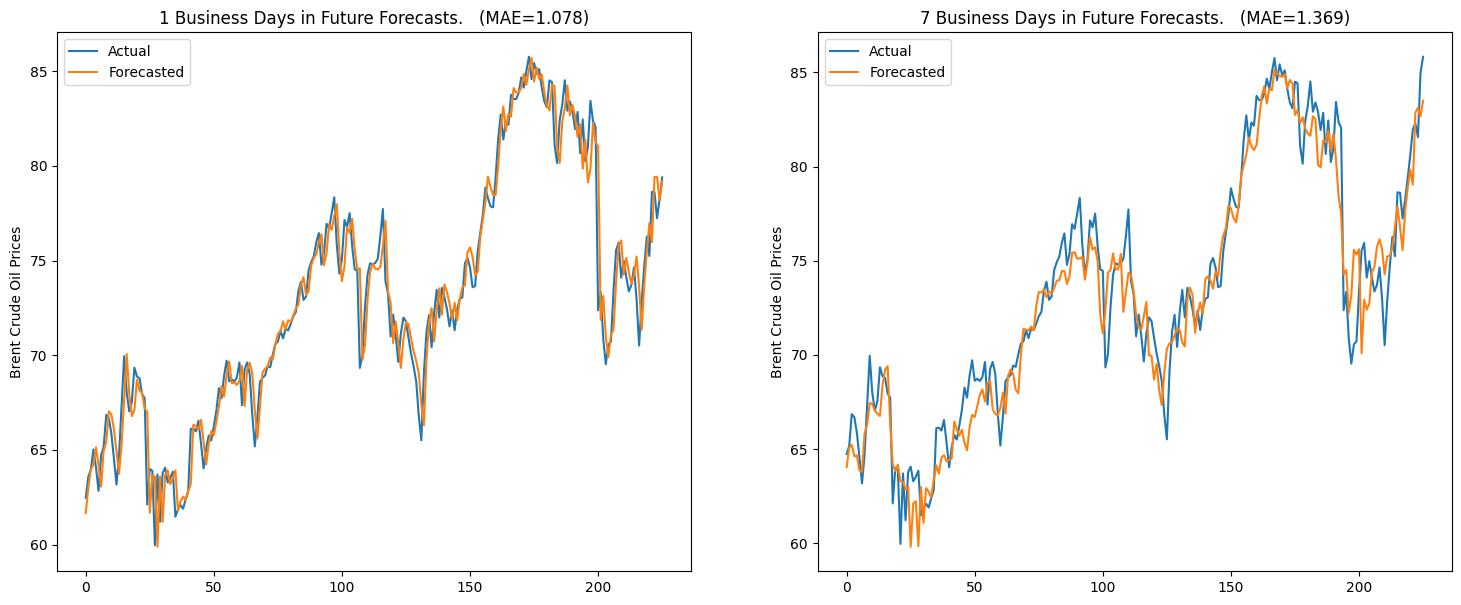

In [ ]:
## making predictions
val_preds = baseline_model.predict(val_X_model)
## invert scale
val_preds = invert_scale(val_preds, train_data_diff['BRENT'])
## get last values for dedifferencing
last_val = get_last_val(val_data.values, 20, 7)
## dedifference predictions
preds = invert_trend(val_preds, last_val)
actual = get_dict(actual_val_y)
preds = get_dict(preds)
model_evaluation(preds, actual)

### We concatenate the train and validation data and fit the model with the same feature's identified above.

In [ ]:
## Concatenate train and validation data for retraining
train_val_X = np.concatenate((train_X_model, val_X_model), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
test_X_model = get_x_imp(test_X, 7)

baseline_model = forecasting_model(20, 7, 7, l2_pen=0, epochs=300)
baseline_model.fit(train_val_X, train_val_y, test_X_model, test_y, silent=True)


Epoch 1: val_loss improved from inf to 0.06117, saving model to my_model.h5

Epoch 2: val_loss improved from 0.06117 to 0.06073, saving model to my_model.h5

Epoch 3: val_loss improved from 0.06073 to 0.06057, saving model to my_model.h5

Epoch 4: val_loss did not improve from 0.06057

Epoch 5: val_loss improved from 0.06057 to 0.05949, saving model to my_model.h5

Epoch 6: val_loss did not improve from 0.05949

Epoch 7: val_loss did not improve from 0.05949

Epoch 8: val_loss did not improve from 0.05949

Epoch 9: val_loss did not improve from 0.05949

Epoch 10: val_loss improved from 0.05949 to 0.05853, saving model to my_model.h5

Epoch 11: val_loss did not improve from 0.05853

Epoch 12: val_loss did not improve from 0.05853

Epoch 13: val_loss did not improve from 0.05853

Epoch 14: val_loss improved from 0.05853 to 0.05791, saving model to my_model.h5

Epoch 15: val_loss did not improve from 0.05791

Epoch 16: val_loss did not improve from 0.05791

Epoch 17: val_loss improved fr

### Evaluating model performance on test data that has been treated as unseen data so far.

4/4 [==============================] - 1s 4ms/step


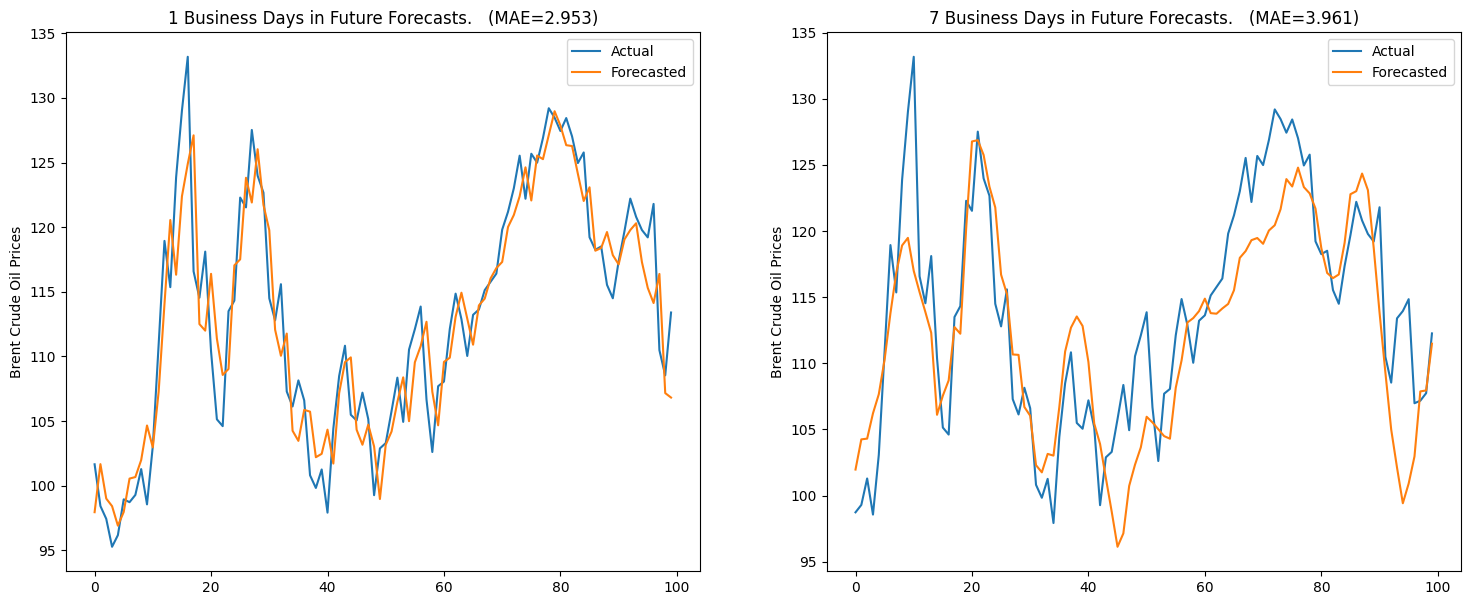

In [ ]:
test_preds = baseline_model.predict(test_X_model)
test_preds = invert_scale(test_preds, train_data_diff['BRENT'])
last_vals = get_last_val(test_data.values, 20, 7)
preds = invert_trend(test_preds, last_vals)
actual = get_dict(actual_test_y)
preds = get_dict(preds)
model_evaluation(preds, actual)

#### Retrain the model on the whole dataset.

In [ ]:
X_data = np.concatenate((train_val_X, test_X_model), axis=0)
y_data = np.concatenate((train_val_y, test_y), axis=0)

model = forecasting_model(20, 7, 7, l2_pen=0, epochs=500)
model.fit(X_data, y_data, silent=True)

## <center><font color='#BAB86C'>Plot Forecasts for the next 7 Business Days</font></center>

1/1 [==============================] - 1s 646ms/step


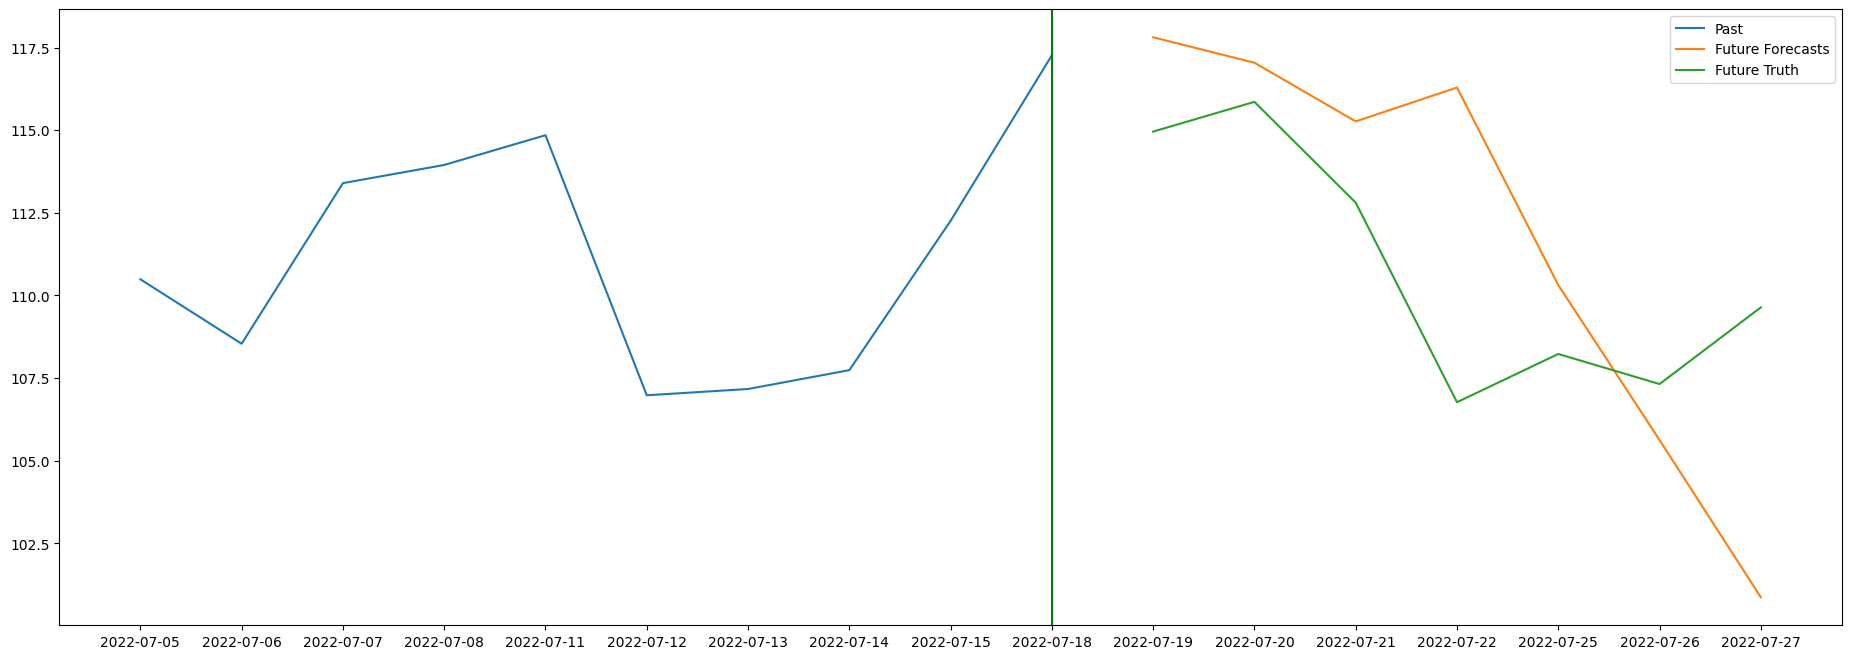

In [ ]:

last_series = test_data['BRENT'].iloc[-10:]

#### WE TAKE THE LAST 20 DATA POINTS TO FORM A SEQUENCES
last_X = np.array([np.array(test_data_diff.iloc[-20:, :])])
last_X = get_x_imp(last_X, 7)

### DEFINE NEXT 7 BUSINESS DAYS FOR THE FUTURE
next_business_days = pd.bdate_range(start=last_series.index[-1], periods=8)[1:]


### WHAT ACTUALLY HAPPENED
actual_next_7 = pd.Series([114.96, 115.86, 112.81, 106.77, 108.23, 107.32, 109.64])
actual_next_7.index = next_business_days
actual_next_7.index = actual_next_7.index.astype('str')

### MAKE PREDICTION ON THE SEQUENCE
forecasts = model.predict(last_X)
forecasts = invert_scale(forecasts, train_data_diff['BRENT'])
forecasts = invert_trend(forecasts, np.array([last_series[-1]]))


#### MAKE A PLOT OF FORECASTS
next_7_days = pd.Series(forecasts[0], index=next_business_days)
next_7_days.index = next_7_days.index.astype('str')
plt.figure(figsize=(23,8))
plt.plot(last_series, label='Past')
plt.plot(next_7_days, label='Future Forecasts')
plt.plot(actual_next_7, label='Future Truth')
plt.axvline(x = last_series.index[-1], color = 'g')
plt.legend()